# ECE 401 Fall 2021 MP4: Ideal and Practical Filters


In this file, we're going to lowpass, bandpass, and highpass filter some EEG signals. The signals we'll be using are samples provided with the MNE package.  It is recommended, but not required, that you first install MME.   You can do so using the instructions on the <a href="https://mne.tools/stable/install/mne_python.html#installing-mne-python-and-its-dependencies">MNE homepage</a>.  On a MAC you will go to a command window, and type 

```
conda create --name=mne --channel=conda-forge mne
conda install --name=base nb_conda_kernels
```
If you don't want to install MNE, you can do the whole MP without it, by simply avoiding the blocks of code marked <b>Requires MNE</b> below.

In [3]:
import os
import numpy as np
import matplotlib.figure
import matplotlib.pyplot
%matplotlib inline
import importlib
import submitted

### Data: With MNE
Here's how the data works.  If you want to use MNE to visualize the data, you first need  to install the `mne` environment as described above.  Then, <b>every time</b> you want to run the MNE code on this page, you'll need to do the following steps:
1. In an operating system command window, type `conda activate mne`, and then `jupyter-notebook`.  That should open up your Jupyter browser, just as if you had opened it from the GUI, except it will make the following steps possible (they wouldn't be possible if you used the GUI).
2. Open this file (`mp4_notebook.ipynb`).
3. Go to the top of this screen, and find the `Kernel` menu.  Under that menu, choose `Change Kernel` -> `Python [conda env:mne]`.

Now you should be able to run the following block of code without errors:

In [4]:
## REQUIRES MNE
import mne,os
os.makedirs(os.path.join(os.path.expanduser('~'),'mne_data'), exist_ok=True)
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder,'MEG','sample','sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True, verbose=False)
data, times = raw.get_data(picks='eeg',return_times=True)
channel_indices_by_type = mne.io.pick.channel_indices_by_type(raw.info)
len(channel_indices_by_type['eeg'])
info = mne.pick_info(raw.info, channel_indices_by_type['eeg'])
print('According to the MNE Info, the Sampling Freq is %g'%(info['sfreq']))

ModuleNotFoundError: No module named 'mne'

### Data: With or Without MNE
If you don't want to use MNE, you can run the following block of code to load the repackaged data.  You should run the following block whether or not you're using MNE, because some of the blocks that follow will use this version of the data.

In [6]:
import h5py
with h5py.File('data.hdf5','r') as f:
    onesecond = f['onesecond'][:]
    sfreq = f['sfreq'][0]
solutions = h5py.File('solutions.hdf5','r')
print('According to data.hdf5, sfreq is %g, nchannels is %d, nsamps is %d'%
     (sfreq, onesecond.shape[0], onesecond.shape[1]))

According to data.hdf5, sfreq is 600.615, nchannels is 60, nsamps is 600


## 1. Browsing the Data
EEG data consists of 60 different voltage signals, recorded in parallel from different electrodes on the scalp.  Here is a function that you can use to choose three of the signals, and plot both the signals and their power spectra:

In [9]:
def plot_waves_and_spectra(signal, sfreq, nrows=3):
    nchannels, nsamps = signal.shape
    t = np.linspace(0,nsamps/sfreq,nsamps,endpoint=False)
    f = np.linspace(0,sfreq,nsamps,endpoint=False)
    fig = matplotlib.figure.Figure(figsize=(14,6))
    axs = fig.subplots(nrows,2)
    channels = np.arange(0,nchannels,int(nchannels/nrows))
    for plotrow in range(nrows):
        channel = channels[plotrow]
        axs[plotrow,0].plot(t,signal[channel,:])
        axs[plotrow,0].set_title('Signal, Channel %d'%(channel))
        axs[plotrow,0].set_ylabel('Volts')
        axs[plotrow,0].set_xlabel('Seconds')
        axs[plotrow,1].plot(f,20*np.log10(1e-3+np.abs(np.fft.fft(signal[channel,:]))))
        axs[plotrow,1].set_title('Spectrum, Channel %d'%(channel))
        axs[plotrow,1].set_xlabel('Hertz')
        axs[plotrow,1].set_ylabel('dB')
    return(fig)

In [10]:
plot_waves_and_spectra(onesecond,sfreq)

ValueError: x and y must have same first dimension, but have shapes (1200,) and (600,)

### Browsing the Data: With MNE
If you have installed MNE, you can use the `plot_topomap` function to see how the voltages are distributed over the scalp at each time step.  Here's a function that plots the voltages as a function of location, for 25 different time steps:

In [7]:
def plot_topomaps(data, info):
    nchannels, nsamps = data.shape
    fig = matplotlib.figure.Figure(figsize=(10,8))
    axs = fig.subplots(5,5)
    for row in range(5):
        for col in range(5):
            samp = int(nsamps*(row*5+col)/25)
            t = samp/info['sfreq']
            mne.viz.plot_topomap(data[:,samp],info,axes=axs[row,col],show=False)
            axs[row,col].set_title('%dms'%(int(np.round(1000*t))))
    return(fig)

Running it requires MNE.  It requires that you have already run the MNE sample-loading  code, up above, to load the `info` object that contains the spatial locations of the electrodes.

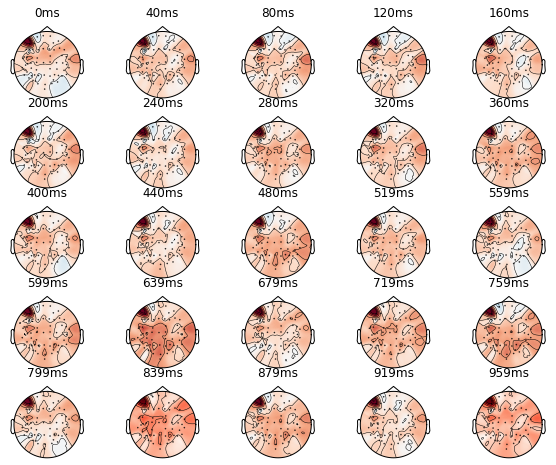

<Figure size 432x288 with 0 Axes>

In [8]:
# REQUIRES MNE
plot_topomaps(onesecond,info)

## 2. Running the MP
Now you're ready to run the MP.  Each block of code, below, will first show you the distributed solution (distributed to  you in the file `solutions.hdf5`), and will then run the code in your own file `submitted.py`, to test whether or not your code works.

In [5]:
def plot_digital_filter(h, sfreq):
    fig = matplotlib.figure.Figure(figsize=(14,6))
    axs = fig.subplots(3,1)
    axs[0].plot(h)
    axs[0].set_title('Impulse response $h[n]$')
    H = np.abs(np.fft.fft(h))
    omega = np.linspace(0,2*np.pi,len(h))
    axs[1].plot(omega,H)
    axs[1].set_title('Magnitude response $|H(\omega)|$')
    f = omega *  sfreq / (2*np.pi)
    axs[2].loglog(f[1:],1e-3+H[1:])
    axs[2].set_title('Log-log plot of magnitude vs. frequency in Hertz')
    return(fig)

### 2.1 todo_lpf_even
This function tests whether or not you can create a lowpass filter with a specified cutoff frequency, and with even length.  The distributed solution contains a 200-sample lowpass filter with a cutoff of pi/4. Notice that the loglog plot doesn't quite know what to do with the aliased part of the filter, up near $\omega=2\pi$.  It isn't really designed to handle the frequency responses of digital filters like this one.

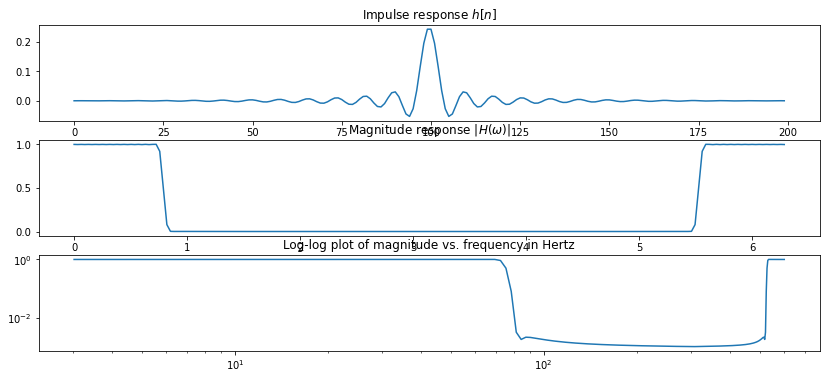

In [6]:
plot_digital_filter(solutions['h_even'],sfreq)

If your code is working, the following block should produce exactly the same plot.  If you haven't written any code yet, the following block will raise a  NotImplementedError.

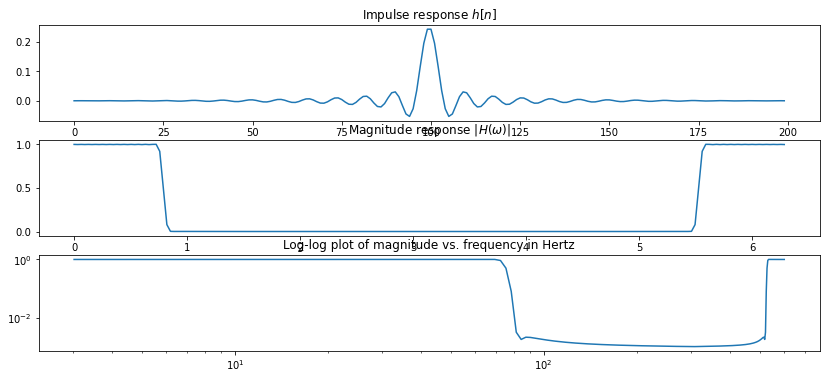

In [7]:
importlib.reload(submitted)
h_even = submitted.todo_lpf_even(200,np.pi/4)
plot_digital_filter(h_even, sfreq)

### 2.2 todo_lpf_odd
This  function creates a lowpass filter with an odd length.  The distributed solution contains an example with length 201, and cutoff of pi/4.

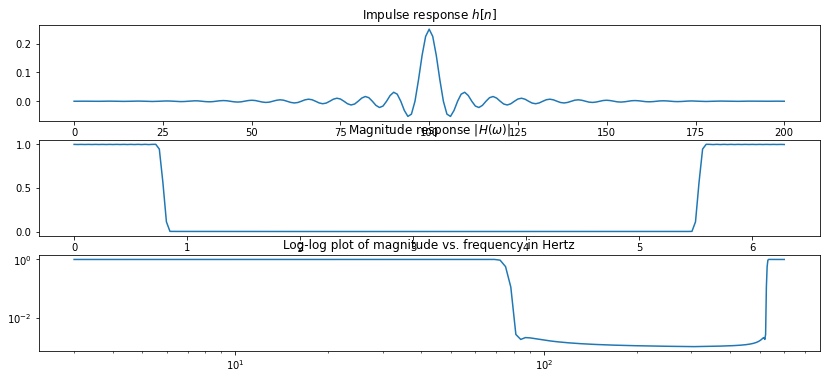

In [8]:
plot_digital_filter(solutions['h_odd'],sfreq)

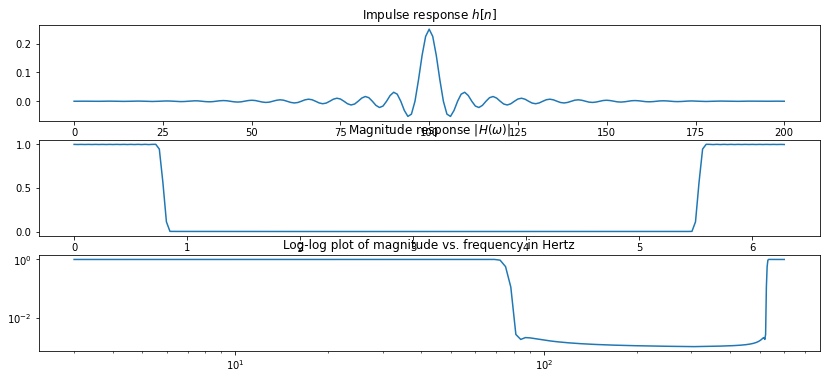

In [10]:
importlib.reload(submitted)
h_odd = submitted.todo_lpf_odd(201,np.pi/4)
plot_digital_filter(h_odd, sfreq)

### 2.3 todo_h_theta
We're going to be a little sloppy, and say that all components of the signal below 7Hz are "theta-waves."   In order to extract those signals, you need to design a lowpass filter with a cutoff at $\omega_L F_s/2\pi=7$Hz, where $F_s$ is the sampling frequency.  The distributed solution creates a filter that's one second long.  

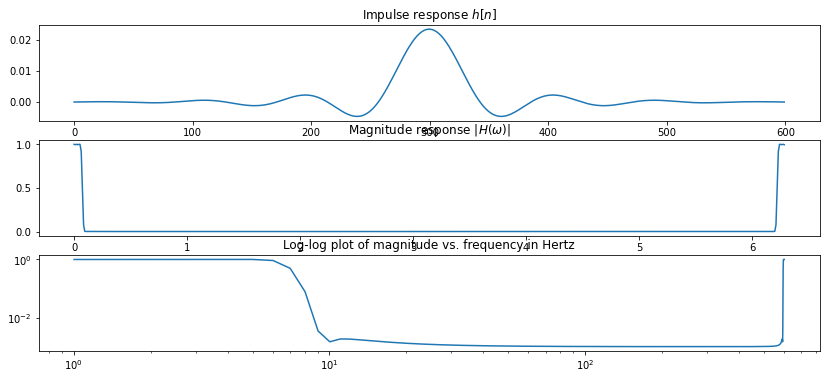

In [20]:
plot_digital_filter(solutions['h_theta'],sfreq)

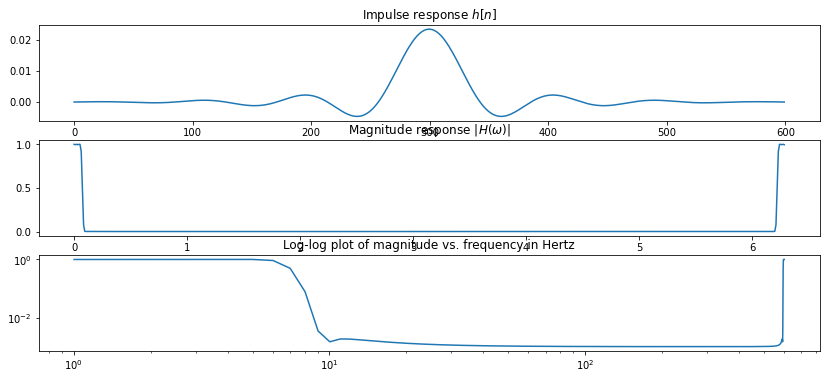

In [21]:
importlib.reload(submitted)
h_theta = submitted.todo_h_theta(sfreq,filterlength=1)
plot_digital_filter(h_theta, sfreq)

### 2.4 todo_convolve
Now let's test to see if you can filter out the theta waves from the sample EEG signals.   Theta waves are supposed to be particularly energetic during sleep, but the sample signal contains a lot of energy at these frequencies. 

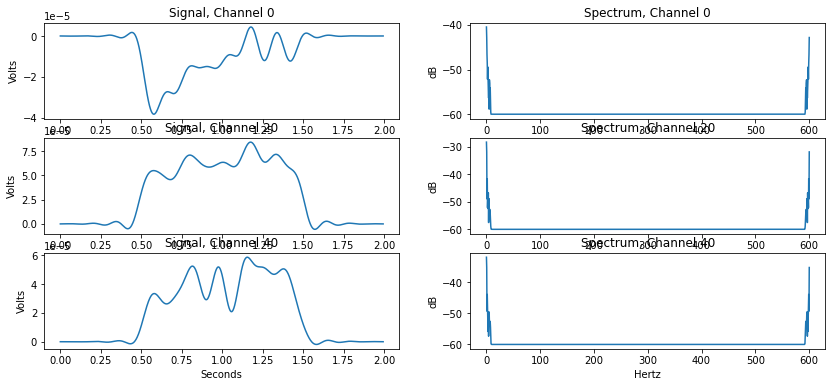

In [22]:
plot_waves_and_spectra(solutions['thetawaves'],sfreq,3)

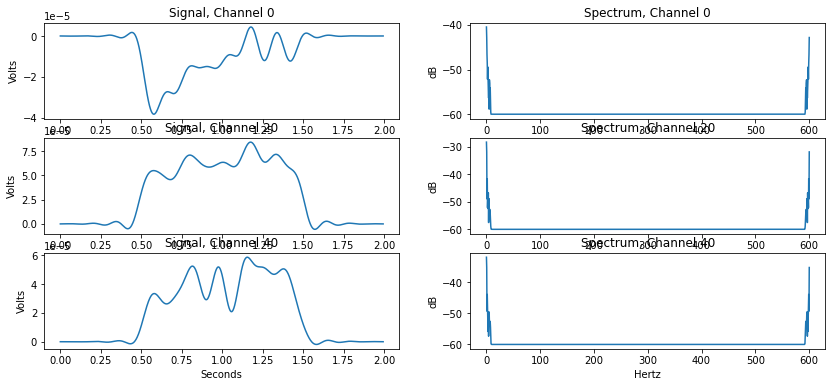

In [23]:
importlib.reload(submitted)
thetawaves = submitted.todo_convolve(onesecond,h_theta)
plot_waves_and_spectra(thetawaves,sfreq,3)

### 2.5 todo_h_alpha
Alpha waves (7-15Hz) are supposed to be particularly active when you are awake but at rest, e.g., when you have your eyes closed.  In  order to filter out alpha waves, let's create an ideal bandpass filter with cutoff frequencies of 7Hz and 14Hz.

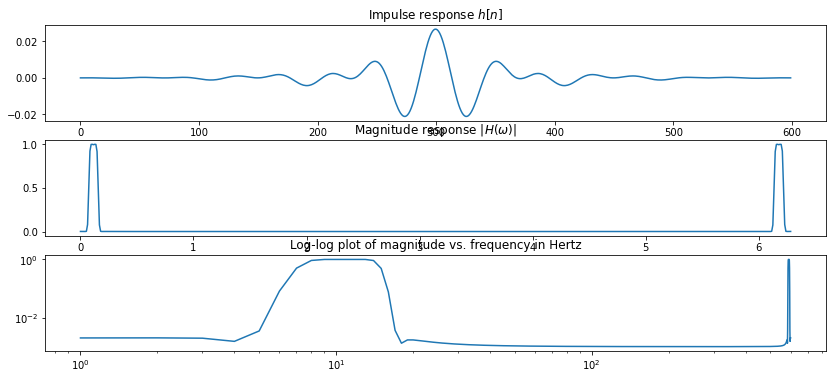

In [24]:
plot_digital_filter(solutions['h_alpha'],sfreq)

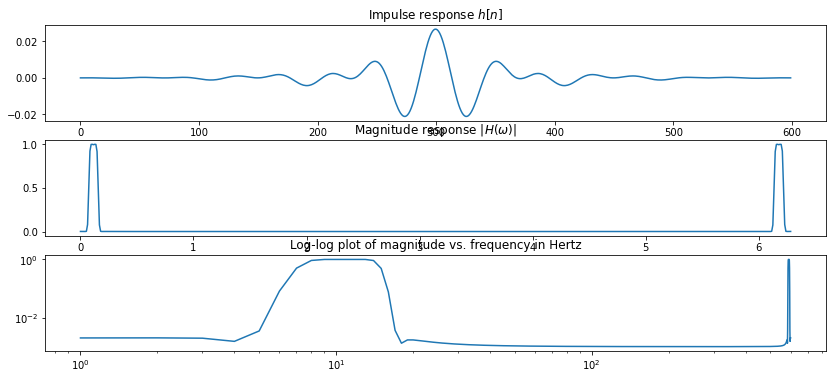

In [25]:
importlib.reload(submitted)
h_alpha = submitted.todo_h_alpha(sfreq, filterlength=1)
plot_digital_filter(h_alpha, sfreq)

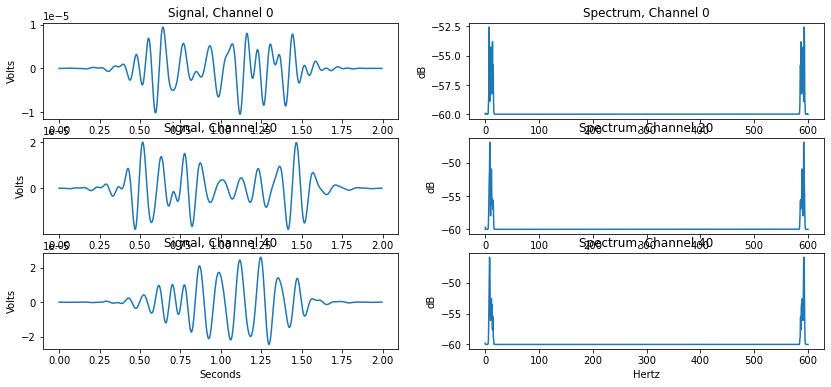

In [26]:
plot_waves_and_spectra(solutions['alphawaves'],sfreq,3)

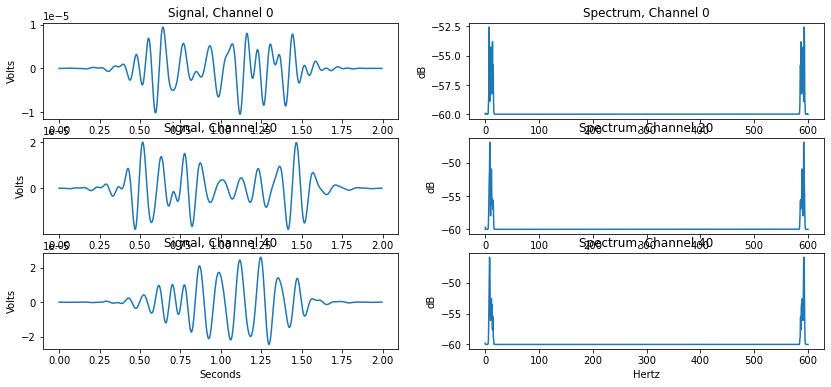

In [27]:
importlib.reload(submitted)
alphawaves = submitted.todo_convolve(onesecond,h_alpha)
plot_waves_and_spectra(alphawaves,sfreq,3)

### 2.6 todo_h_beta
Beta waves (15-30Hz) are supposed to be active whenever you are conscious.  I find it interesting that this sample contains a lot of synchronous events (spikes that occur at the same time in different channels) in the beta band.  

Many of the events that are reported in evoked-potential studies happen in the theta, alpha, and beta bands.  For example, if the P150 and N300 events are of opposite polarity (positive and negative) and 150ms apart, then the fundamental frequency of that pair of events is 1/0.3=3.33Hz, which is in the theta band.  Its third and fourth harmonics are in the alpha band, and its fifth through ninth harmonics are in the beta band. 

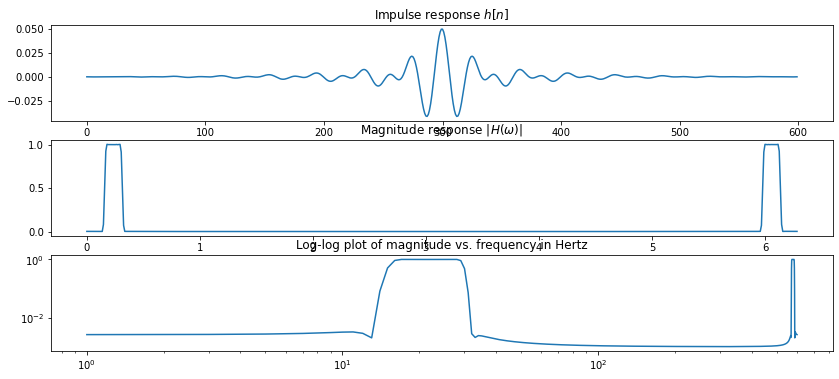

In [28]:
plot_digital_filter(solutions['h_beta'],sfreq)

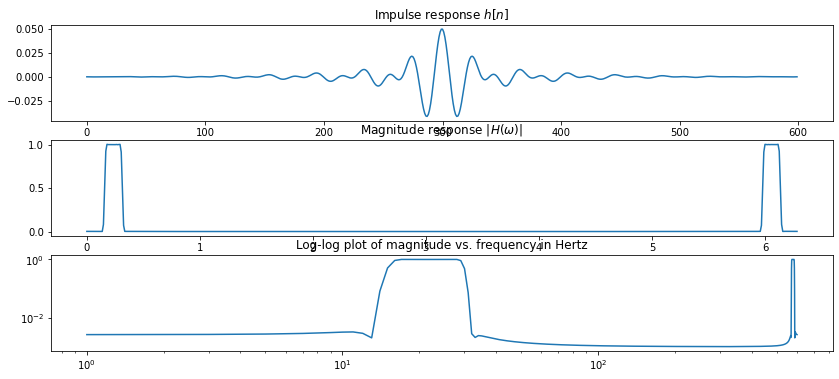

In [29]:
importlib.reload(submitted)
h_beta = submitted.todo_h_beta(sfreq, filterlength=1)
plot_digital_filter(h_beta, sfreq)

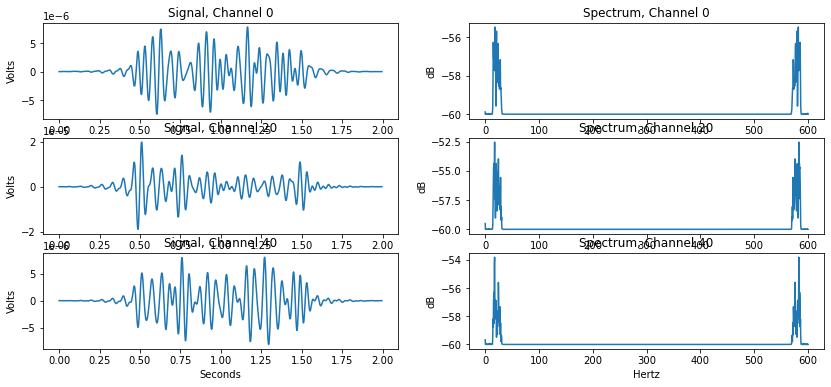

In [30]:
plot_waves_and_spectra(solutions['betawaves'],sfreq,3)

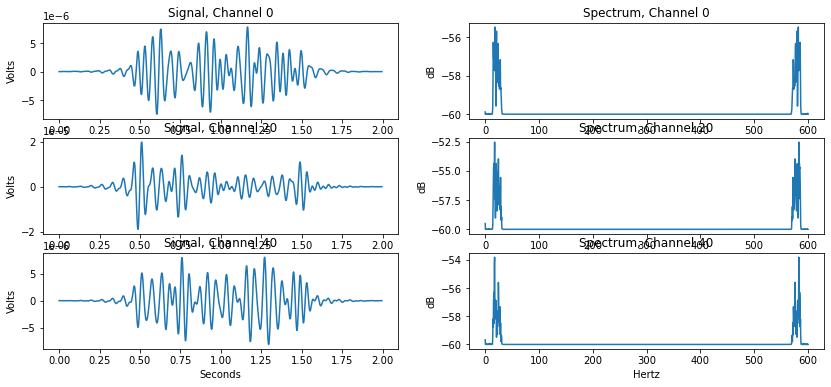

In [31]:
importlib.reload(submitted)
betawaves = submitted.todo_convolve(onesecond,h_beta)
plot_waves_and_spectra(betawaves,sfreq,3)

### 2.7 todo_h_gamma
Gamma waves (above 30Hz) may contain some of the detailed modulations that distinguish different types  of perceptual input.   We will extract the gamma band using a highpass filter, which has two very different forms, depending on whether the filter length is odd or even:
* odd filter  length: $$h[n] = \delta[n] - LPF$$
* even filter length: $$h[n] = \sin(\pi n)/(\pi n) - LPF$$

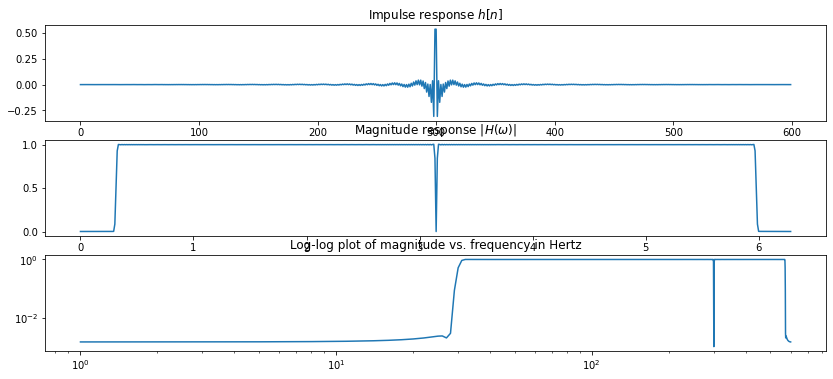

In [32]:
plot_digital_filter(solutions['h_gamma'],sfreq)

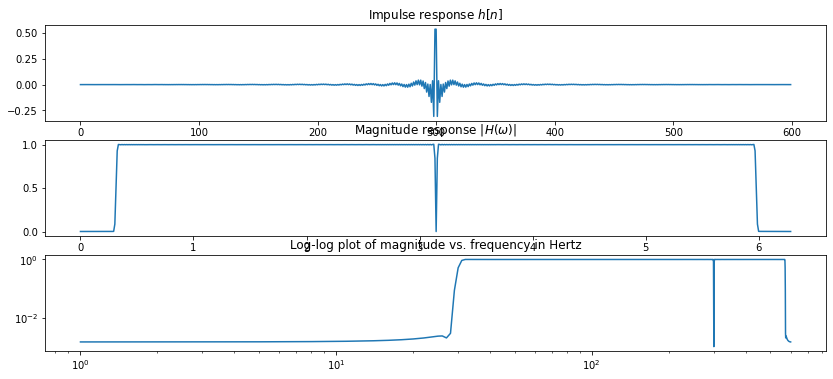

In [33]:
importlib.reload(submitted)
h_gamma = submitted.todo_h_gamma(sfreq, filterlength=1)
plot_digital_filter(h_gamma, sfreq)

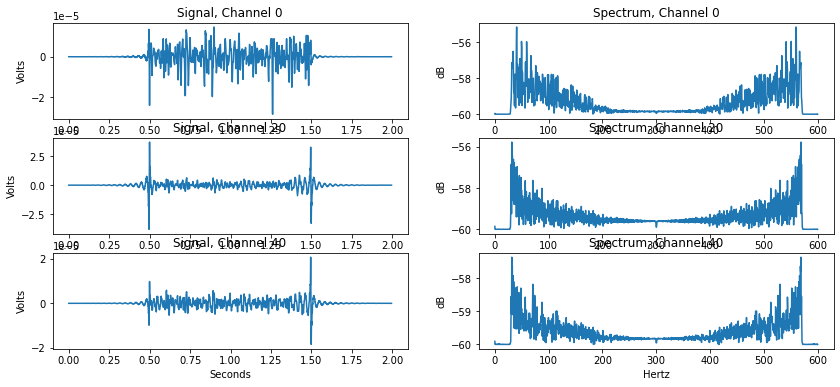

In [34]:
plot_waves_and_spectra(solutions['gammawaves'],sfreq,3)

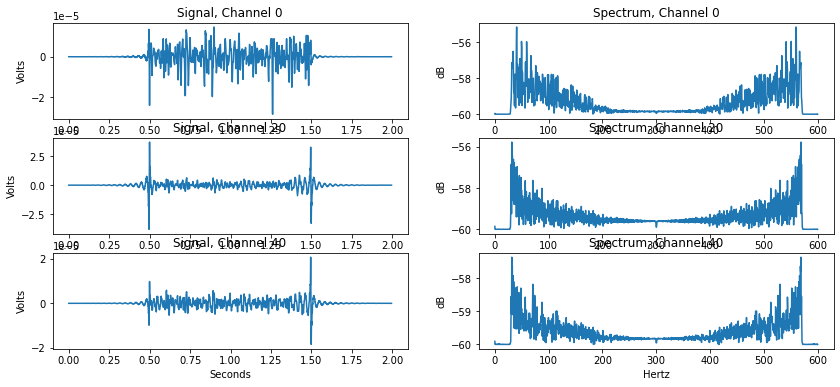

In [35]:
importlib.reload(submitted)
gammawaves = submitted.todo_convolve(onesecond,h_gamma)
plot_waves_and_spectra(gammawaves,sfreq,3)

That's all!  If  all of the above sections worked, try running `python grade.py` on the command line.  If that also works, then try uploading your `submitted.py` file to the autograder.